## Setup

In [1]:
source("/path/to/the/project/02_notebooks/00_setup.r")

In [2]:
p_load("biomaRt", "dplyr", "ggplot2", "forcats", "clusterProfiler", "msigdbr", 
       "ReactomePA", "rWikiPathways", "enrichplot", "org.Mm.eg.db", "AnnotationDbi", "fgsea", "enrichR", install = FALSE)

In [3]:
enrichr_to_plot <- function(dataframe, database){
    tmp = dataframe[[database]] %>% top_n(10, wt = Combined.Score) %>% tidyr::separate("Overlap", sep = "/", into = c("Gene_number", "max")) 
    tmp$Gene_number = as.numeric(tmp$Gene_number)
    tmp = tmp %>% arrange(desc(Gene_number))

    

    tf_p <- ggplot(as.data.frame(tmp), aes(x = reorder(Term, Gene_number), y = Gene_number, fill = -log(Adjusted.P.value, base=10))) +
    geom_bar(stat ="identity", width = 0.5, alpha = 0.8) +
    coord_flip() +
    labs(x="Pathways", y="Number of genes", fill="Adjusted P-value (log10)", title = paste0("Pathway enrichment using ", database)) +
    theme(axis.text=element_text(size=20)) + 
    theme(legend.position="none") +
    theme(axis.text.x = element_text(color="black", 
                            size=20),
            axis.text.y = element_text(color="black", 
                            size=20)) +
    theme_light() + scale_fill_gradient(
    low = "#AEBAF8", 
    high = "#9600FF"
    )


tf_p 
}
    
setEnrichrSite("Enrichr")
dbs <- listEnrichrDbs()
dbs <- c("MSigDB_Hallmark_2020", "Reactome_2022", "WikiPathways_2019_Mouse")

Connection changed to https://maayanlab.cloud/Enrichr/

Connection is Live!



## Deconvolution

In [1]:
#https://www.bioconductor.org/packages/release/bioc/vignettes/PFP/inst/doc/PFP.html

In [5]:
enrichr_kc_cd63 <- read.delim("01_raw_data/gsea/KC_cd63_MSigDB_Hallmark_2020_table.txt", sep = "\t")

In [ ]:
enrichr_kc_marco <- read.delim("01_raw_data/gsea/KC_marco_MSigDB_Hallmark_2020_table.txt", sep = "\t")

In [ ]:
enrichr_kc_cd63 <- enrichr_kc_cd63 %>% filter(Adjusted.P.value < 0.05)
enrichr_kc_cd63$Term <- factor(enrichr_kc_cd63$Term, levels = enrichr_kc_cd63$Term) %>% fct_rev()

In [ ]:
enrichr_kc_marco <- enrichr_kc_marco %>% filter(Adjusted.P.value < 0.05)

In [ ]:
enrichr_kc_marco <- enrichr_kc_marco %>% filter(Adjusted.P.value < 0.05)
enrichr_kc_marco <- enrichr_kc_marco %>% arrange(Combined.Score)
enrichr_kc_marco$Term <- factor(enrichr_kc_marco$Term, levels = enrichr_kc_marco$Term) 

In [ ]:
p_1 <- ggplot(enrichr_kc_cd63, aes(x= Term, y=Combined.Score)) +
  geom_bar(stat ="identity", fill="#c15ca5", width = 0.55, alpha = 0.8) +
  coord_flip() +
  labs(x="Pathways", y="Combined enrichR score", fill="", title = "MSigDB Hallmark 2020: Kupffer_cells_Cd63_Lgals3bp") +
  theme(axis.text=element_text(size=10)) + 
  theme(legend.position="none") +
 theme(axis.text.x = element_text(color="black", 
                           size=14),
          axis.text.y = element_text(color="black", 
                           size=14)) +
    theme_light() 
p_1

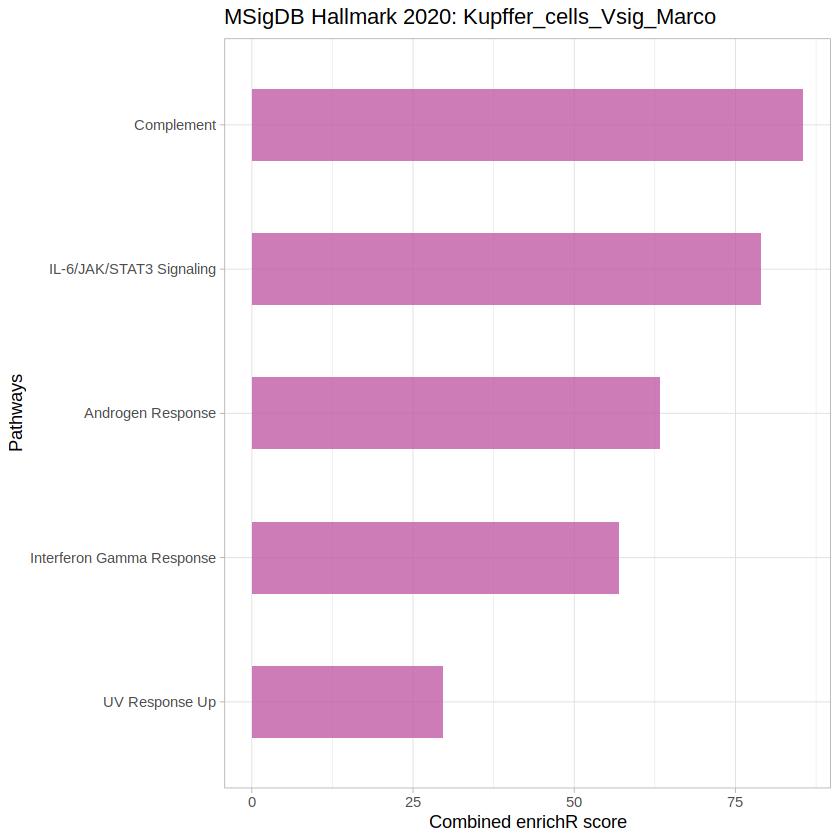

In [87]:
p_2 <- ggplot(enrichr_kc_marco, aes(x= Term, y=Combined.Score)) +
  geom_bar(stat ="identity", fill="#c15ca5", width = 0.5, alpha = 0.8) +
  coord_flip() +
  labs(x="Pathways", y="Combined enrichR score", fill="", title = "MSigDB Hallmark 2020: Kupffer_cells_Vsig_Marco") +
  theme(axis.text=element_text(size=10)) + 
  theme(legend.position="none") +
 theme(axis.text.x = element_text(color="black", 
                           size=14),
          axis.text.y = element_text(color="black", 
                           size=14)) +
    theme_light() 
p_2 

## Cirrhosis DE

In [4]:
ccl4_sig <- read.csv("03_outputs/03/de_ccl4_cpos_cneg_sig_wald.csv")
taa_sig <- read.csv("03_outputs/03/de_taa_cpos_cneg_sig_wald.csv")

In [5]:
ccl4_up <- read.csv("03_outputs/03/de_ccl4_cpos_cneg_sig_up_wald.csv")
ccl4_down <- read.csv("03_outputs/03/de_taa_cpos_cneg_sig_down_wald.csv")

taa_up <- read.csv("03_outputs/03/de_ccl4_cpos_cneg_sig_up_wald.csv")
taa_down <- read.csv("03_outputs/03/de_taa_cpos_cneg_sig_down_wald.csv")

In [6]:
up_intersect <- intersect(ccl4_up$X, taa_up$X)
down_intersect <- intersect(ccl4_down$X, taa_down$X)

In [7]:
ranks_ccl4 <- ccl4_sig %>% mutate(rank = (sign(log2FoldChange) / (-log(pvalue)))) %>% dplyr::select(X, rank) %>% tibble::deframe()
ranks_taa <- taa_sig %>% mutate(rank = (sign(log2FoldChange) / (-log(pvalue)))) %>% dplyr::select(X, rank) %>% tibble::deframe()
# ranks_ccl4_up <- ccl4_cpos_cneg_up %>% dplyr::select(X, padj) %>% tibble::deframe()
# ranks_taa_down <- taa_cpos_cneg_down %>% dplyr::select(X, padj) %>% tibble::deframe()
# ranks_taa_up <- taa_cpos_cneg_up %>% dplyr::select(X, padj) %>% tibble::deframe()

In [12]:
pathways <- gmtPathways("99_technical/m2.cp.wikipathways.v2023.1.Mm.symbols.gmt")
fgseaRes_ccl4 <- fgsea(pathways=pathways, stats=ranks_ccl4)
fgseaRes_taa <- fgsea(pathways=pathways, stats=ranks_taa)

Warning message in preparePathwaysAndStats(pathways, stats, minSize, maxSize, gseaParam, :
"There are ties in the preranked stats (0.18% of the list).
The order of those tied genes will be arbitrary, which may produce unexpected results."
Warning message in preparePathwaysAndStats(pathways, stats, minSize, maxSize, gseaParam, :
"There are ties in the preranked stats (0.11% of the list).
The order of those tied genes will be arbitrary, which may produce unexpected results."


In [16]:
tmp <- fgseaRes_ccl4 %>% arrange(NES) %>% filter(pathway == "WP_PPAR_SIGNALING_PATHWAY")
tmp$leadingEdge

[[1]]
 [1] "Rxrb"    "Acadl"   "Apoa1"   "Acadm"   "Cyp4a14" "Fabp2"   "Cyp4a32"
 [8] "Angptl4" "Scd1"    "Adipoq"  "Rxra"    "Apoa5"   "Acox3"   "Ehhadh" 
[15] "Hmgcs2"  "Cpt2"    "Pltp"    "Acaa1b"  "Pck1"    "Acaa1a"  "Cyp8b1" 
[22] "Slc27a5" "Acox1"   "Slc27a2" "Fabp1"   "Ilk"     "Acsl1"   "Me1"    
[29] "Scp2"

In [ ]:

fgseaRes_ccl4 <- fgseaRes_ccl4 %>% as.data.frame() %>% arrange(desc(NES)) %>% 
  dplyr::select(-leadingEdge, -ES) %>% arrange(padj)
fgseaRes_taa <- fgseaRes_taa %>% as.data.frame() %>% arrange(desc(NES)) %>% 
  dplyr::select(-leadingEdge, -ES) %>% arrange(padj)

Connection changed to https://maayanlab.cloud/Enrichr/

Connection is Live!



Uploading data to Enrichr... Done.
  Querying MSigDB_Hallmark_2020... Done.
  Querying Reactome_2022... Done.
  Querying WikiPathways_2019_Mouse... Done.
Parsing results... Done.


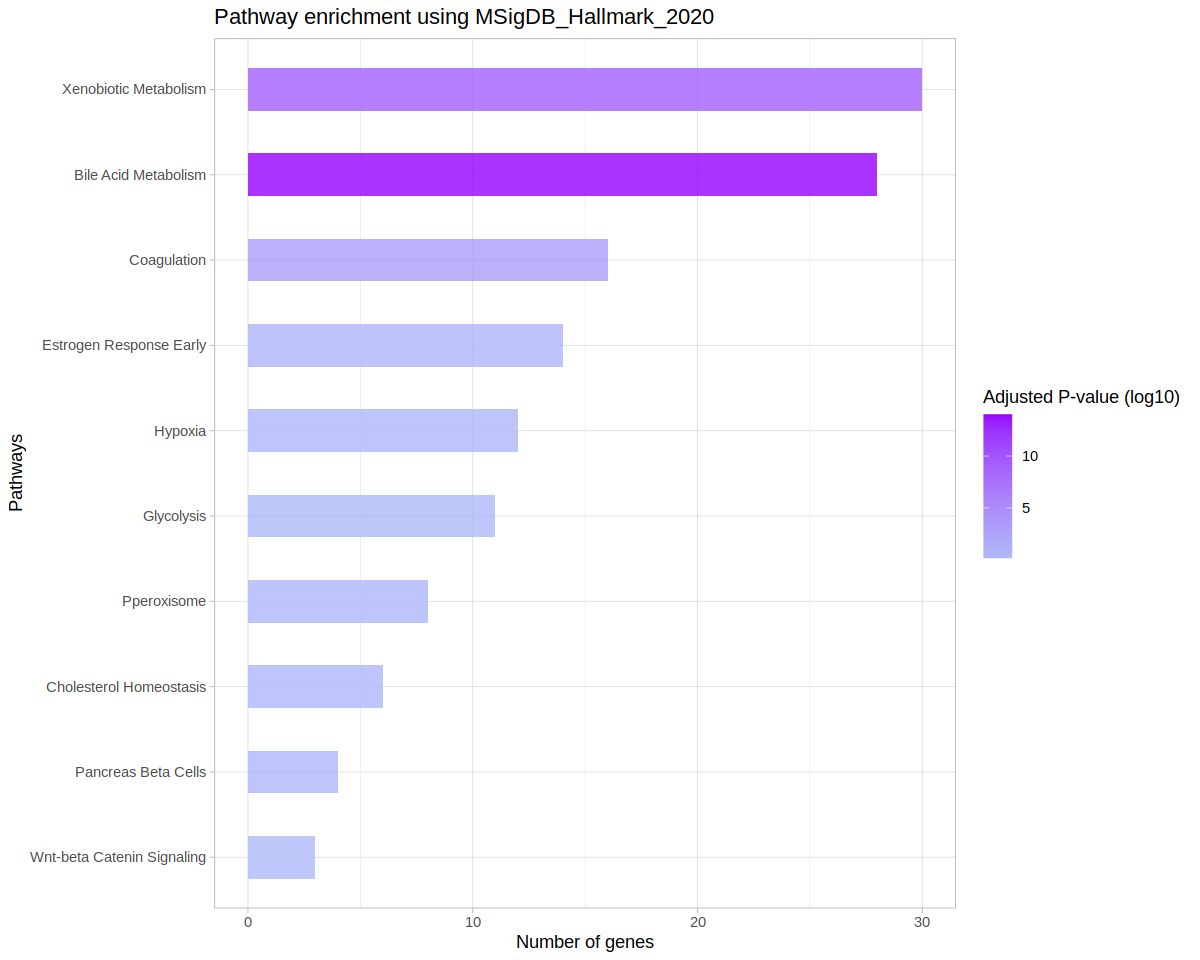

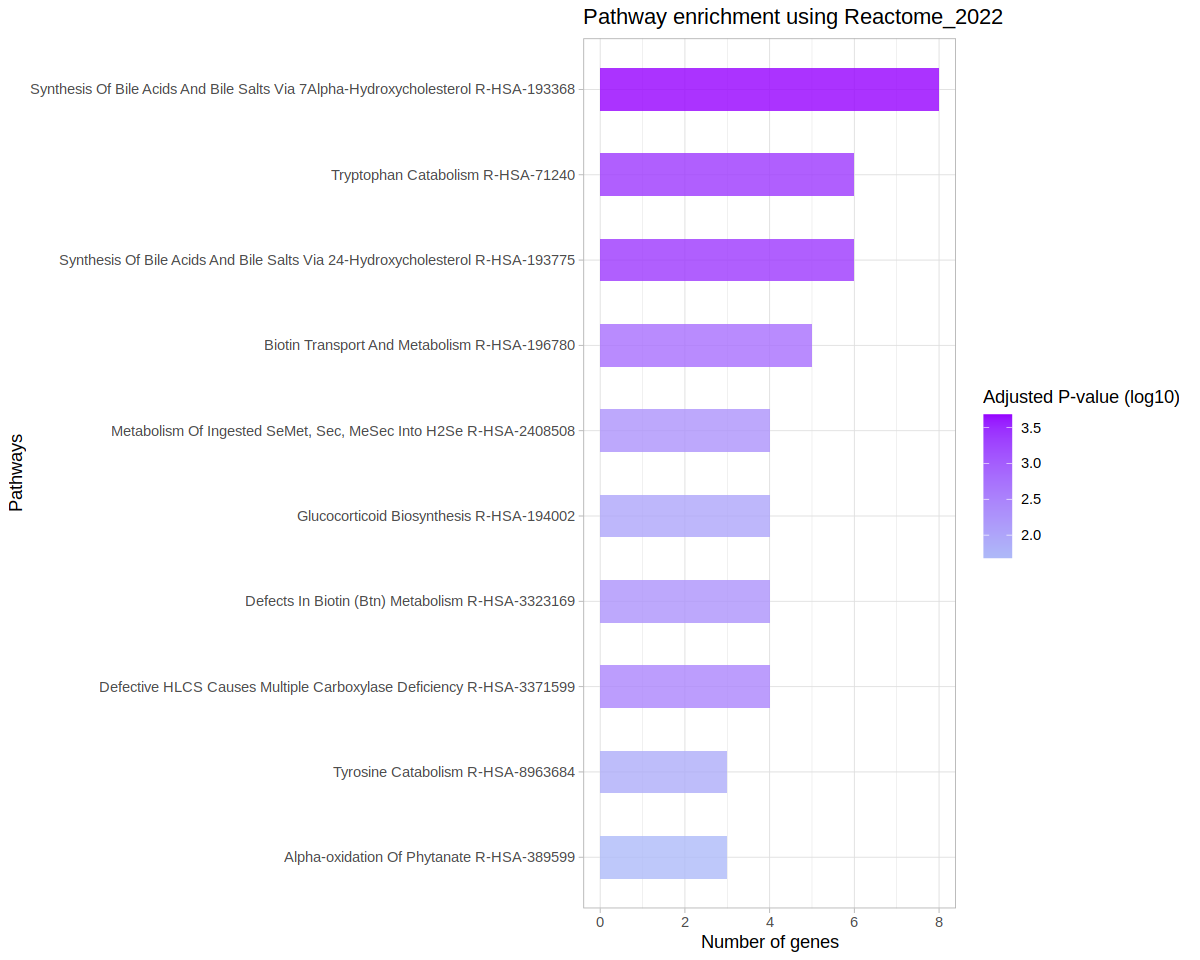

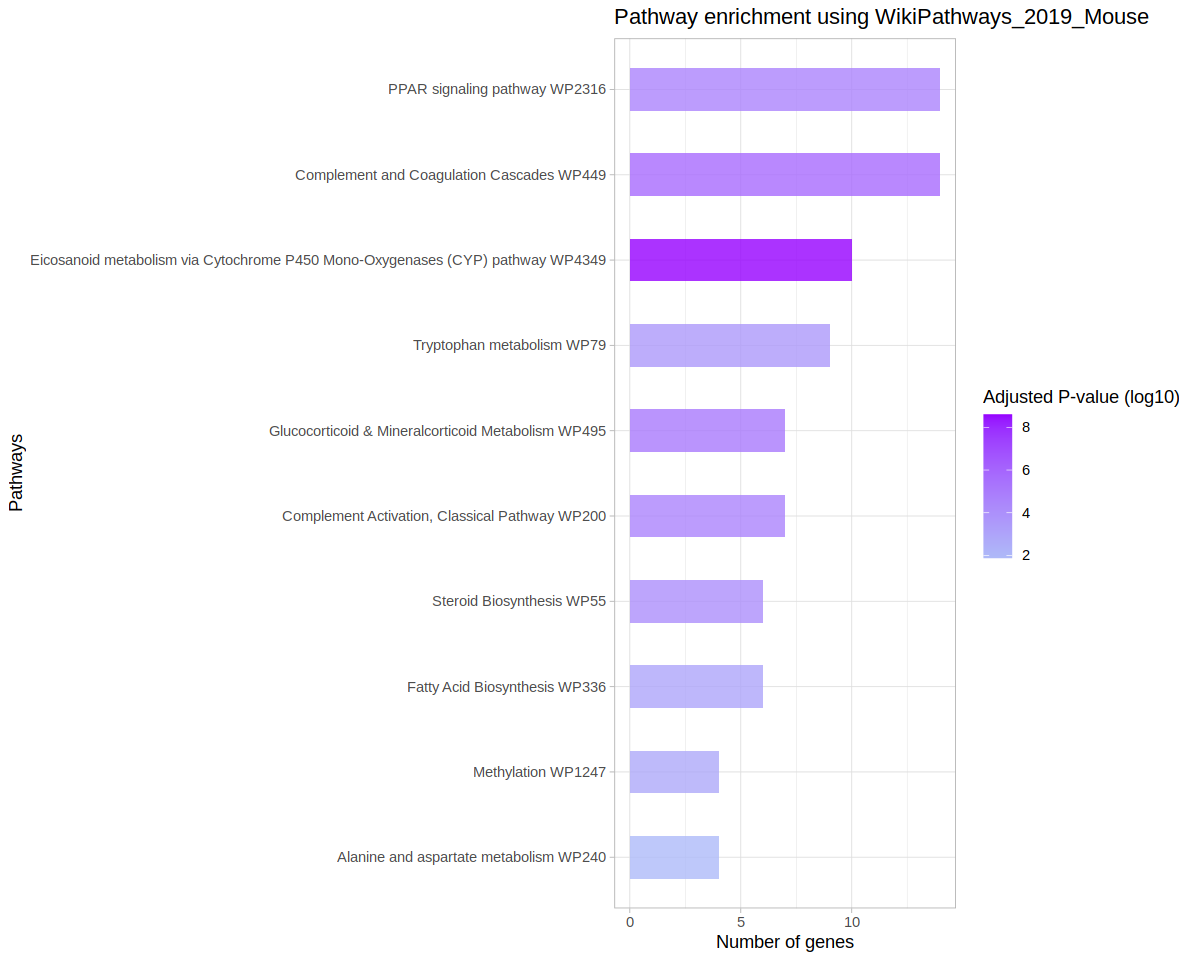

In [84]:
down_intersect <- enrichr(down_intersect, dbs)
for (db in dbs){
    plot <- enrichr_to_plot(down_intersect, db)
    print(plot)
}

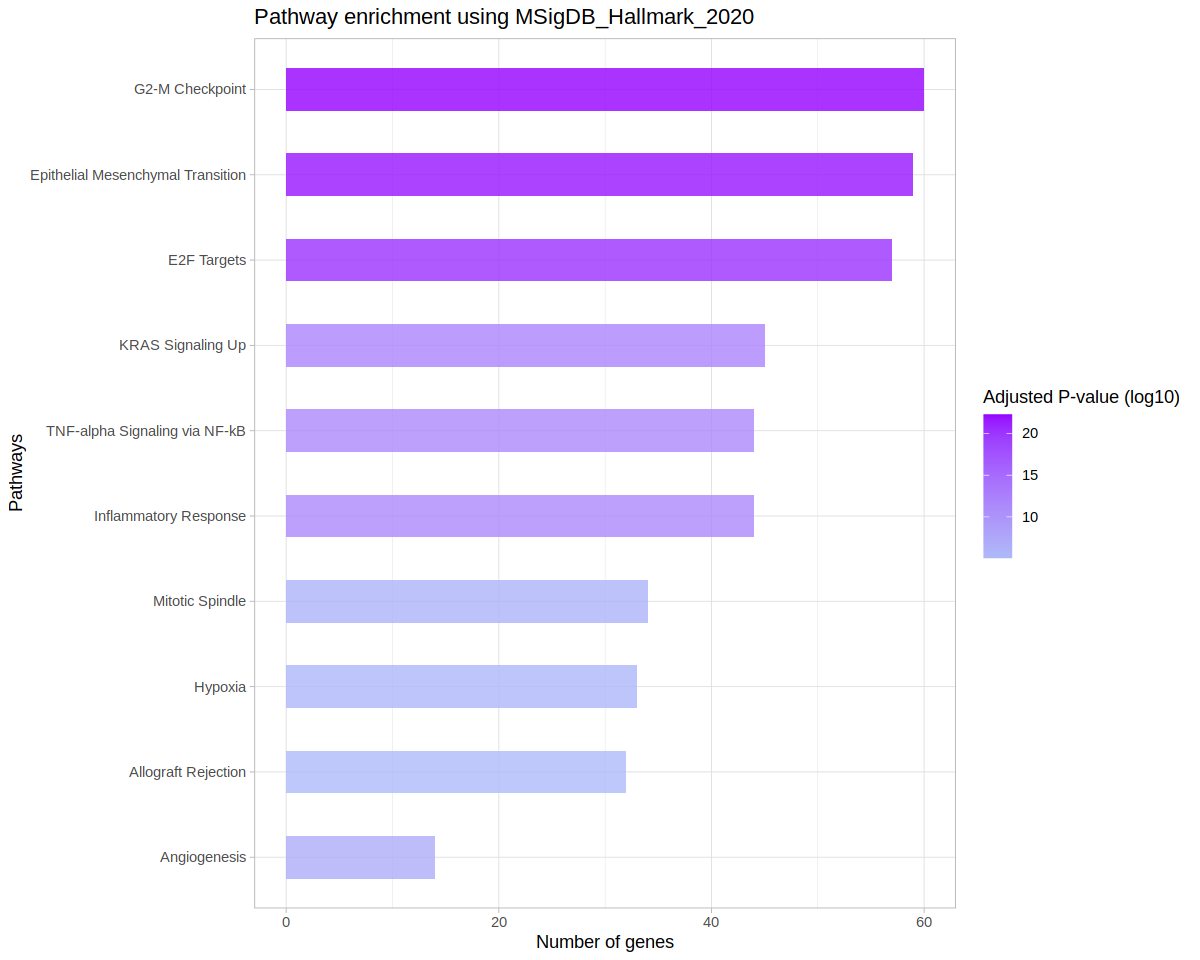

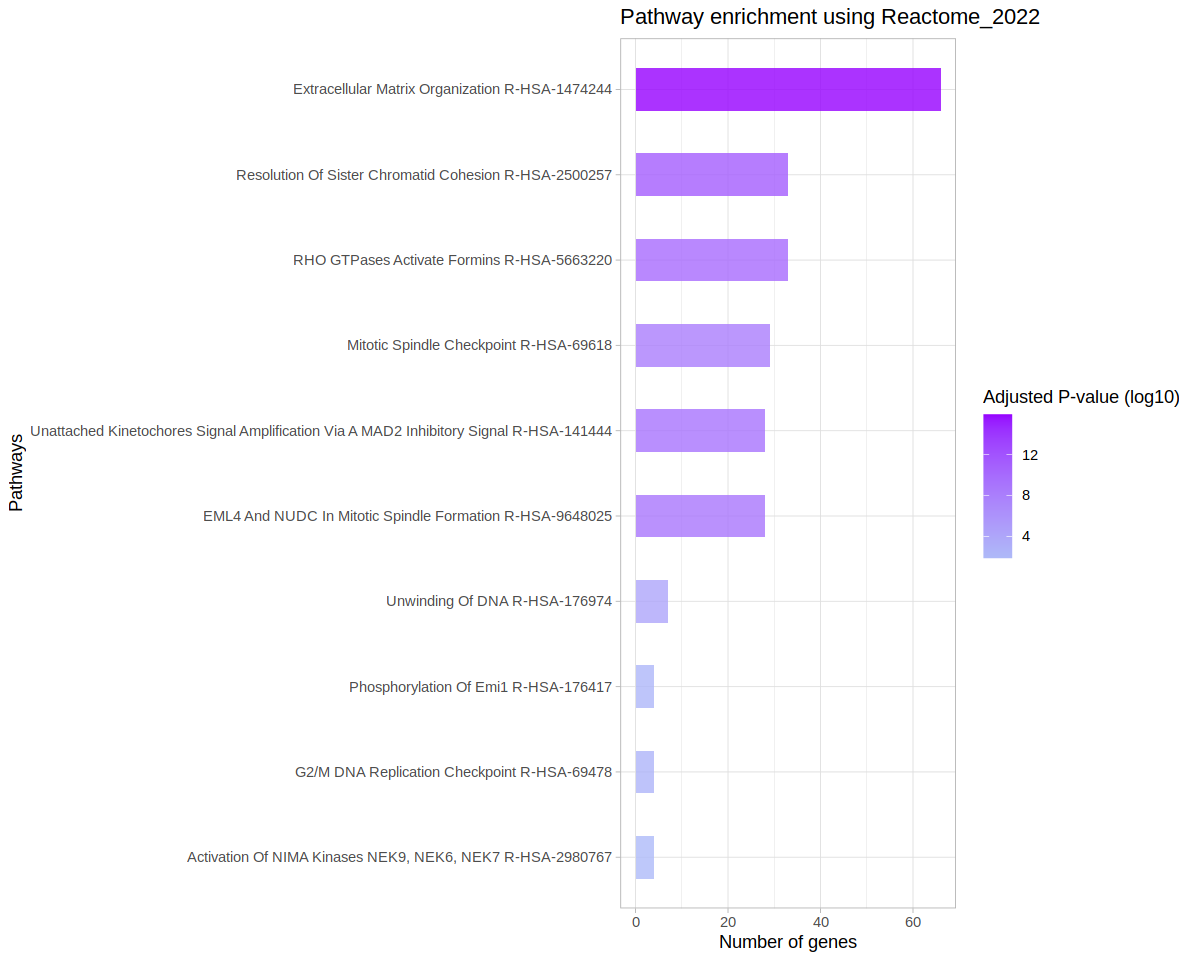

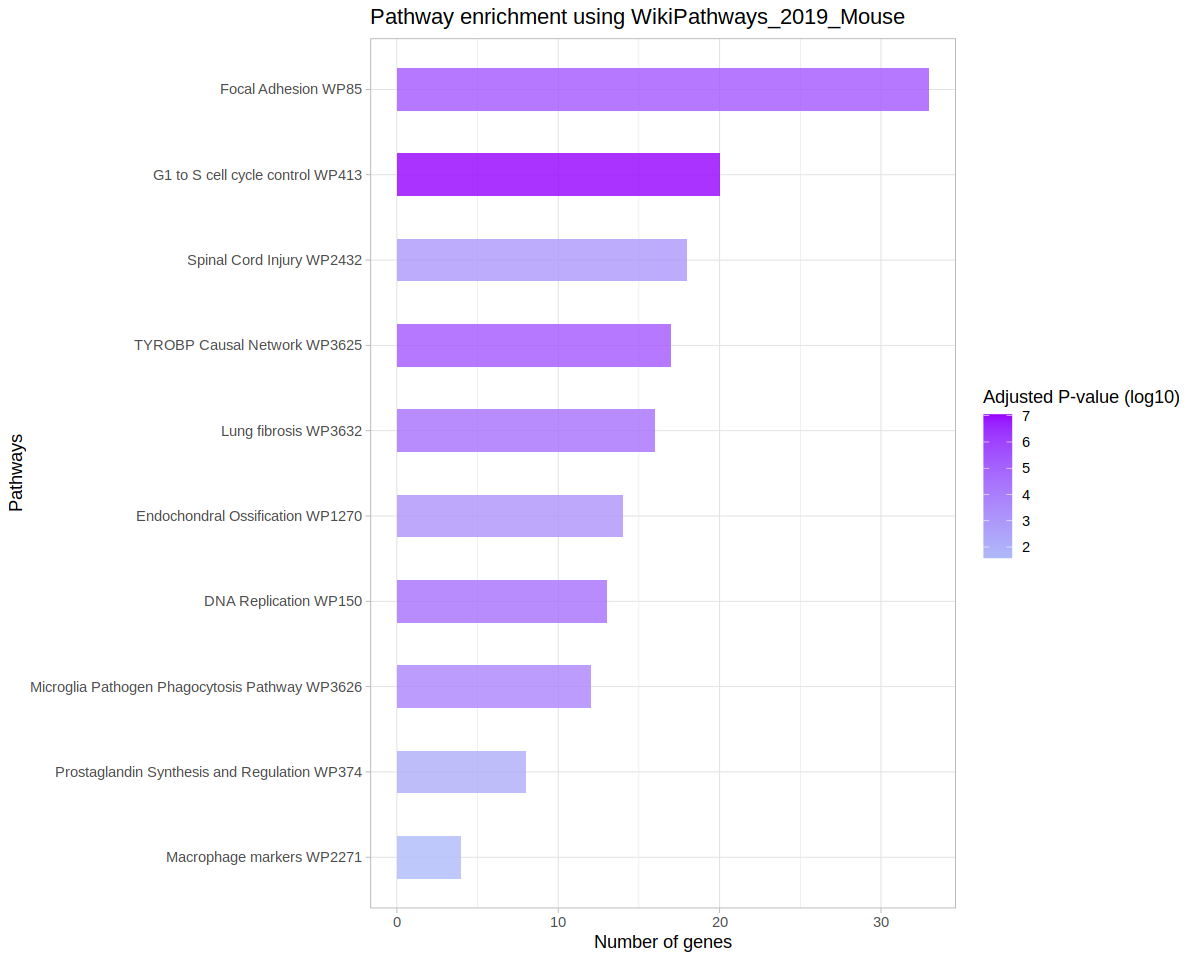

In [78]:
options(repr.plot.width = 6, repr.plot.height = 6, repr.point.size = 16)
for (db in dbs){
    plot <- enrichr_to_plot(up_intersect, db)
    print(plot)
}

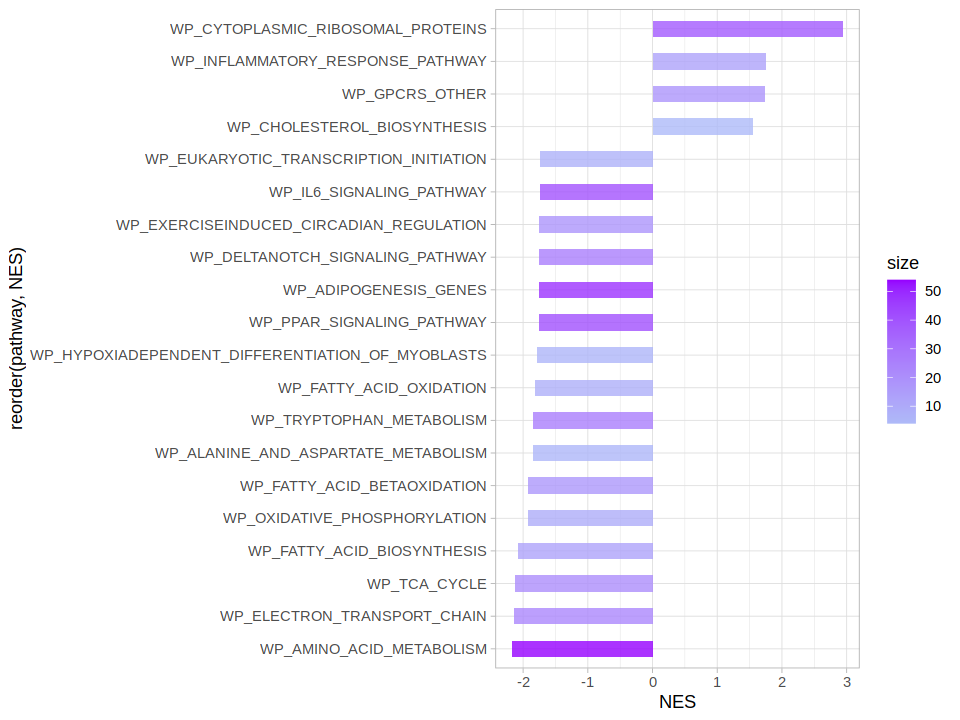

In [62]:
options(repr.plot.width = 8, repr.plot.height = 6, repr.point.size = 16)
ggplot((fgseaRes_ccl4 %>% filter(padj < 0.25) %>% arrange(desc(size))), 
    aes(x = reorder(pathway, NES), y = NES, fill = size)) +
    geom_bar(stat ="identity", width = 0.5, alpha = 0.8) +
    coord_flip() +
 #   labs(x="Pathways", y="Number of genes", fill="Adjusted P-value (log10)", title = paste0("Pathway enrichment using ", database)) +
    theme(axis.text=element_text(size=20)) + 
    theme(legend.position="none") +
    theme(axis.text.x = element_text(color="black", 
                            size=20),
            axis.text.y = element_text(color="black", 
                            size=20)) +
    theme_light() + scale_fill_gradient(
    low = "#AEBAF8", 
    high = "#9600FF"
    )

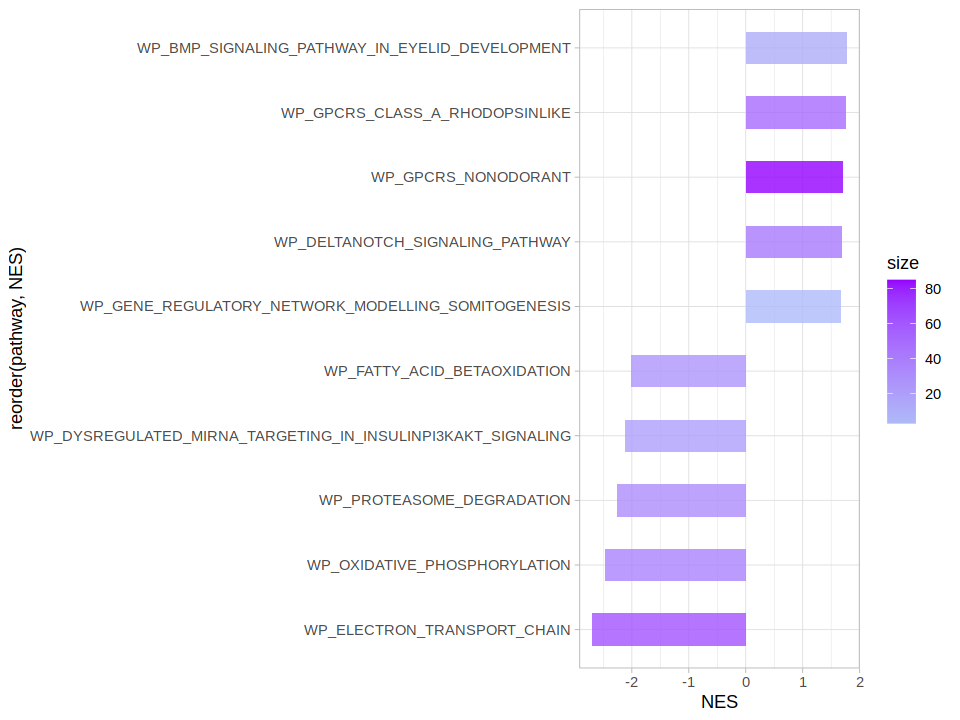

In [61]:
options(repr.plot.width = 8, repr.plot.height = 6, repr.point.size = 16)
ggplot((fgseaRes_taa %>% filter(padj < 0.25) %>% arrange(desc(size))), 
    aes(x = reorder(pathway, NES), y = NES, fill = size)) +
    geom_bar(stat ="identity", width = 0.5, alpha = 0.8) +
    coord_flip() +
 #   labs(x="Pathways", y="Number of genes", fill="Adjusted P-value (log10)", title = paste0("Pathway enrichment using ", database)) +
    theme(axis.text=element_text(size=20)) + 
    theme(legend.position="none") +
    theme(axis.text.x = element_text(color="black", 
                            size=20),
            axis.text.y = element_text(color="black", 
                            size=20)) +
    theme_light() + scale_fill_gradient(
    low = "#AEBAF8", 
    high = "#9600FF"
    )

## Regression DE

In [26]:
ccl4_r_sig <- read.csv("03_outputs/03/de_ccl4_reg_pos_sig_wald.csv")
taa_r_sig <- read.csv("03_outputs/03/de_taa_reg_pos_sig_wald.csv")

Warning message in preparePathwaysAndStats(pathways, stats, minSize, maxSize, gseaParam, :
"There are ties in the preranked stats (0.19% of the list).
The order of those tied genes will be arbitrary, which may produce unexpected results."
Warning message in preparePathwaysAndStats(pathways, stats, minSize, maxSize, gseaParam, :
"There are ties in the preranked stats (0.15% of the list).
The order of those tied genes will be arbitrary, which may produce unexpected results."


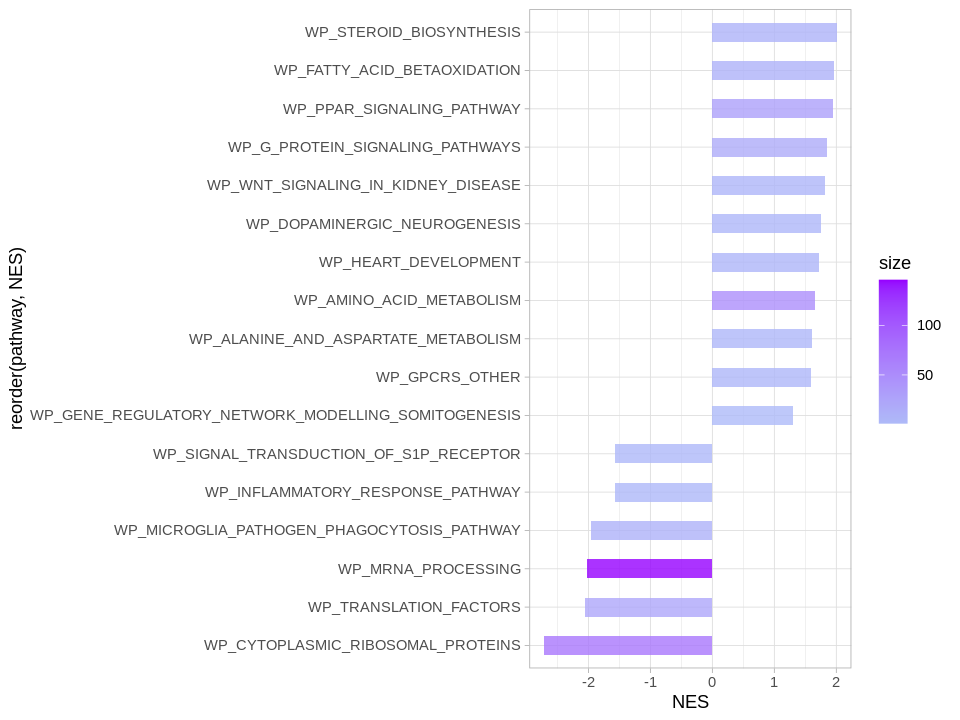

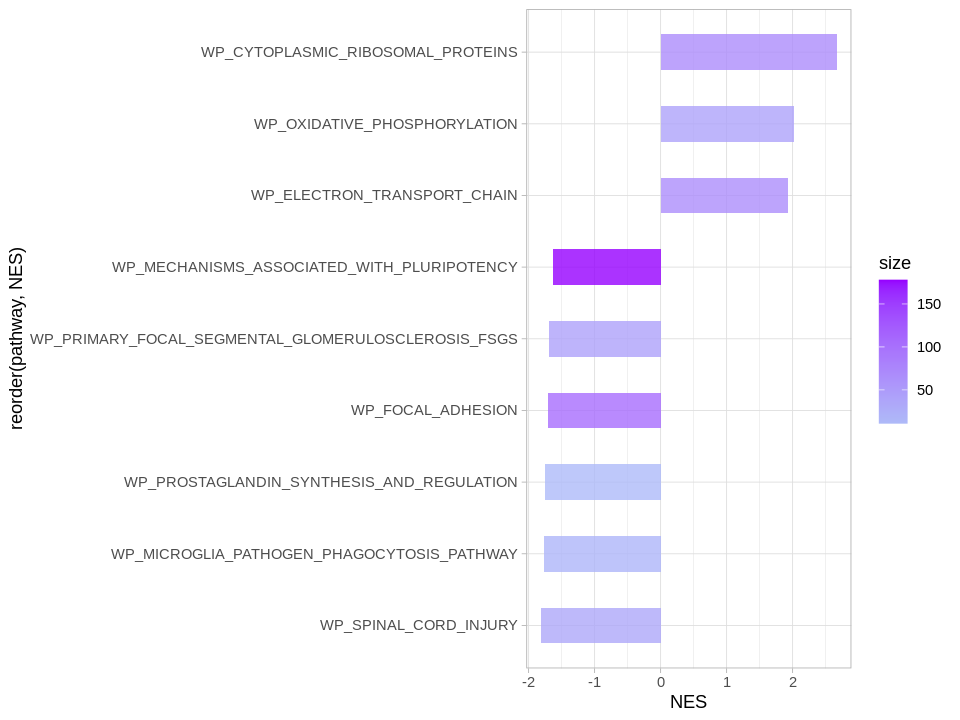

In [33]:
ranks_ccl4_r <- ccl4_r_sig %>% mutate(rank = (sign(log2FoldChange) / (-log(pvalue)))) %>% dplyr::select(X, rank) %>% tibble::deframe()
ranks_taa_r <- taa_r_sig %>% mutate(rank = (sign(log2FoldChange) / (-log(pvalue)))) %>% dplyr::select(X, rank) %>% tibble::deframe()

pathways <- gmtPathways("99_technical/m2.cp.wikipathways.v2023.1.Mm.symbols.gmt")
fgseaRes_ccl4_r <- fgsea(pathways=pathways, stats=ranks_ccl4_r)
fgseaRes_taa_r <- fgsea(pathways=pathways, stats=ranks_taa_r)


fgseaRes_ccl4_r <- fgseaRes_ccl4_r %>% as.data.frame() %>% arrange(desc(NES)) %>% 
  dplyr::select(-leadingEdge, -ES) %>% arrange(padj)
fgseaRes_taa_r <- fgseaRes_taa_r %>% as.data.frame() %>% arrange(desc(NES)) %>% 
  dplyr::select(-leadingEdge, -ES) %>% arrange(padj)

options(repr.plot.width = 8, repr.plot.height = 6, repr.point.size = 16)
ggplot((fgseaRes_ccl4_r %>% filter(padj < 0.25) %>% arrange(desc(size))), 
    aes(x = reorder(pathway, NES), y = NES, fill = size)) +
    geom_bar(stat ="identity", width = 0.5, alpha = 0.8) +
    coord_flip() +
 #   labs(x="Pathways", y="Number of genes", fill="Adjusted P-value (log10)", title = paste0("Pathway enrichment using ", database)) +
    theme(axis.text=element_text(size=20)) + 
    theme(legend.position="none") +
    theme(axis.text.x = element_text(color="black", 
                            size=20),
            axis.text.y = element_text(color="black", 
                            size=20)) +
    theme_light() + scale_fill_gradient(
    low = "#AEBAF8", 
    high = "#9600FF"
    )

options(repr.plot.width = 8, repr.plot.height = 6, repr.point.size = 16)
ggplot((fgseaRes_taa_r %>% filter(padj < 0.25) %>% arrange(desc(size))), 
    aes(x = reorder(pathway, NES), y = NES, fill = size)) +
    geom_bar(stat ="identity", width = 0.5, alpha = 0.8) +
    coord_flip() +
 #   labs(x="Pathways", y="Number of genes", fill="Adjusted P-value (log10)", title = paste0("Pathway enrichment using ", database)) +
    theme(axis.text=element_text(size=20)) + 
    theme(legend.position="none") +
    theme(axis.text.x = element_text(color="black", 
                            size=20),
            axis.text.y = element_text(color="black", 
                            size=20)) +
    theme_light() + scale_fill_gradient(
    low = "#AEBAF8", 
    high = "#9600FF"
    )

In [4]:
ccl4_up_reg <- read.csv("03_outputs/03/de_ccl4_reg_pos_sig_up_wald.csv")
ccl4_down_reg <- read.csv("03_outputs/03/de_ccl4_reg_pos_sig_down_wald.csv")
taa_up_reg <- read.csv("03_outputs/03/de_taa_reg_pos_sig_up_wald.csv")
taa_down_reg <- read.csv("03_outputs/03/de_taa_reg_pos_sig_down_wald.csv")

In [5]:
up_intersect <- intersect(ccl4_up_reg$X, taa_up_reg$X)
down_intersect <- intersect(ccl4_down_reg$X, taa_down_reg$X)

In [51]:
options(repr.plot.width = 12, repr.plot.height = 6, repr.point.size = 16)

In [56]:
tmp <- enrichr(up_intersect, "MSigDB_Hallmark_2020")

Uploading data to Enrichr... Done.
  Querying MSigDB_Hallmark_2020... Done.
Parsing results... Done.


In [57]:
tmp <- tmp$MSigDB_Hallmark_2020 %>% top_n(., 7, Combined.Score) 

In [58]:
tmp <- head(tmp, 7)

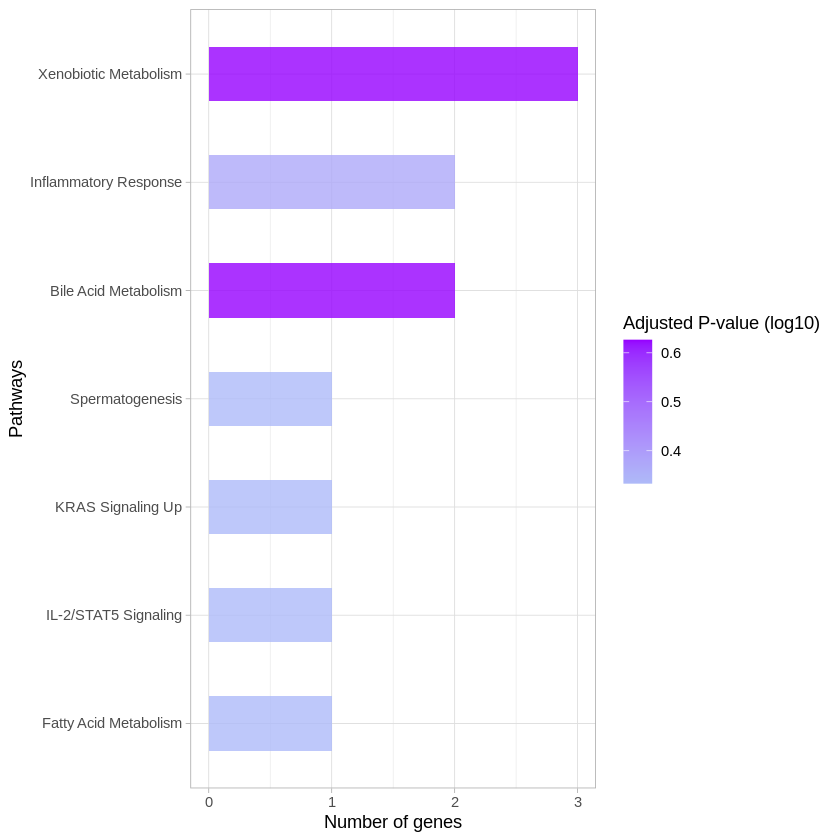

In [59]:
    tmp <- tmp %>% tidyr::separate("Overlap", sep = "/", into = c("Gene_number", "max")) 
    tmp$Gene_number = as.numeric(tmp$Gene_number)
    tmp = tmp %>% arrange(desc(Gene_number))
    tf_p <- ggplot(as.data.frame(tmp), aes(x = reorder(Term, Gene_number), y = Gene_number, fill = -log(Adjusted.P.value, base=10))) +
    geom_bar(stat ="identity", width = 0.5, alpha = 0.8) +
    coord_flip() +
    labs(x="Pathways", y="Number of genes", fill="Adjusted P-value (log10)") +
    theme(axis.text=element_text(size=20)) + 
    theme(legend.position="none") +
    theme(axis.text.x = element_text(color="black", 
                            size=20),
            axis.text.y = element_text(color="black", 
                            size=20)) +
    theme_light() + scale_fill_gradient(
    low = "#AEBAF8", 
    high = "#9600FF"
    )


tf_p 

## Model-specific pathways

In [4]:
res_ccl4_taa_cir <- read.csv("03_outputs/03/res_ccl4_taa_cir.csv", row.names = 1)
res_ccl4_taa_r1 <- read.csv("03_outputs/03/res_ccl4_taa_r1_r1.csv", row.names = 1)
res_ccl4_taa_r2 <- read.csv("03_outputs/03/res_ccl4_taa_r2_r2.csv", row.names = 1)

In [5]:
cir_unique <- res_ccl4_taa_cir %>% filter(padj < 0.01)
r1_unique <- res_ccl4_taa_r1 %>% filter(padj < 0.01)
r2_unique <- res_ccl4_taa_r2 %>% filter(padj < 0.01)

In [6]:
pathways <- gmtPathways("99_technical/m2.cp.wikipathways.v2023.1.Mm.symbols.gmt")

ranks_cir_u <- cir_unique %>% mutate(rank = (sign(log2FoldChange) / (-log(pvalue)))) %>% tibble::rownames_to_column("X") %>% dplyr::select(X, rank) %>% tibble::deframe()
fgsea_cir_unique <- fgsea(pathways=pathways, stats=ranks_cir_u)
fgsea_cir_unique <- fgsea_cir_unique %>% as.data.frame() %>% arrange(desc(NES)) %>% 
  dplyr::select(-leadingEdge, -ES) %>% arrange(padj)

ranks_r1_u <- r1_unique %>% mutate(rank = (sign(log2FoldChange) / (-log(pvalue)))) %>% tibble::rownames_to_column("X") %>% dplyr::select(X, rank) %>% tibble::deframe()
fgsea_r1_unique <- fgsea(pathways=pathways, stats=ranks_r1_u)
fgsea_r1_unique <- fgsea_r1_unique %>% as.data.frame() %>% arrange(desc(NES)) %>% 
  dplyr::select(-leadingEdge, -ES) %>% arrange(padj)

ranks_r2_u <- r2_unique %>% mutate(rank = (sign(log2FoldChange) / (-log(pvalue)))) %>% tibble::rownames_to_column("X") %>% dplyr::select(X, rank) %>% tibble::deframe()
fgsea_r2_unique <- fgsea(pathways=pathways, stats=ranks_r2_u)
fgsea_r2_unique <- fgsea_r2_unique %>% as.data.frame() %>% arrange(desc(NES)) %>% 
  dplyr::select(-leadingEdge, -ES) %>% arrange(padj)

Warning message in preparePathwaysAndStats(pathways, stats, minSize, maxSize, gseaParam, :
"There are ties in the preranked stats (0.1% of the list).
The order of those tied genes will be arbitrary, which may produce unexpected results."
Warning message in preparePathwaysAndStats(pathways, stats, minSize, maxSize, gseaParam, :
"There are ties in the preranked stats (0.08% of the list).
The order of those tied genes will be arbitrary, which may produce unexpected results."


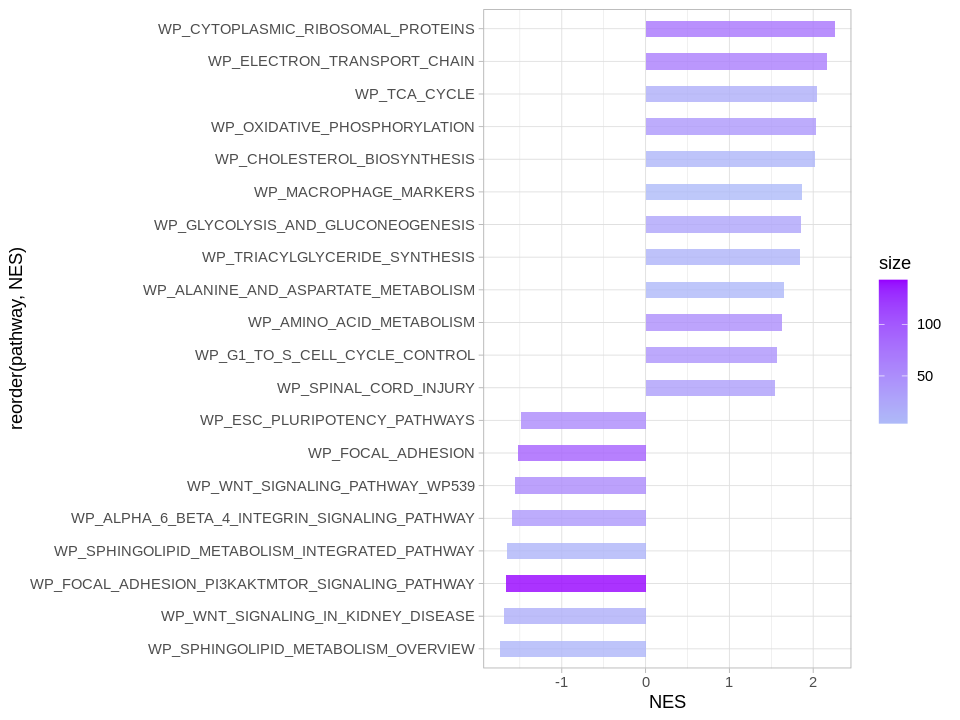

In [15]:
options(repr.plot.width = 8, repr.plot.height = 6, repr.point.size = 16)
ggplot((fgsea_cir_unique %>% filter(padj < 0.25) %>% arrange(desc(size))), 
    aes(x = reorder(pathway, NES), y = NES, fill = size)) +
    geom_bar(stat ="identity", width = 0.5, alpha = 0.8) +
    coord_flip() +
 #   labs(x="Pathways", y="Number of genes", fill="Adjusted P-value (log10)", title = paste0("Pathway enrichment using ", database)) +
    theme(axis.text=element_text(size=20)) + 
    theme(legend.position="none") +
    theme(axis.text.x = element_text(color="black", 
                            size=20),
            axis.text.y = element_text(color="black", 
                            size=20)) +
    theme_light() + scale_fill_gradient(
    low = "#AEBAF8", 
    high = "#9600FF"
    )

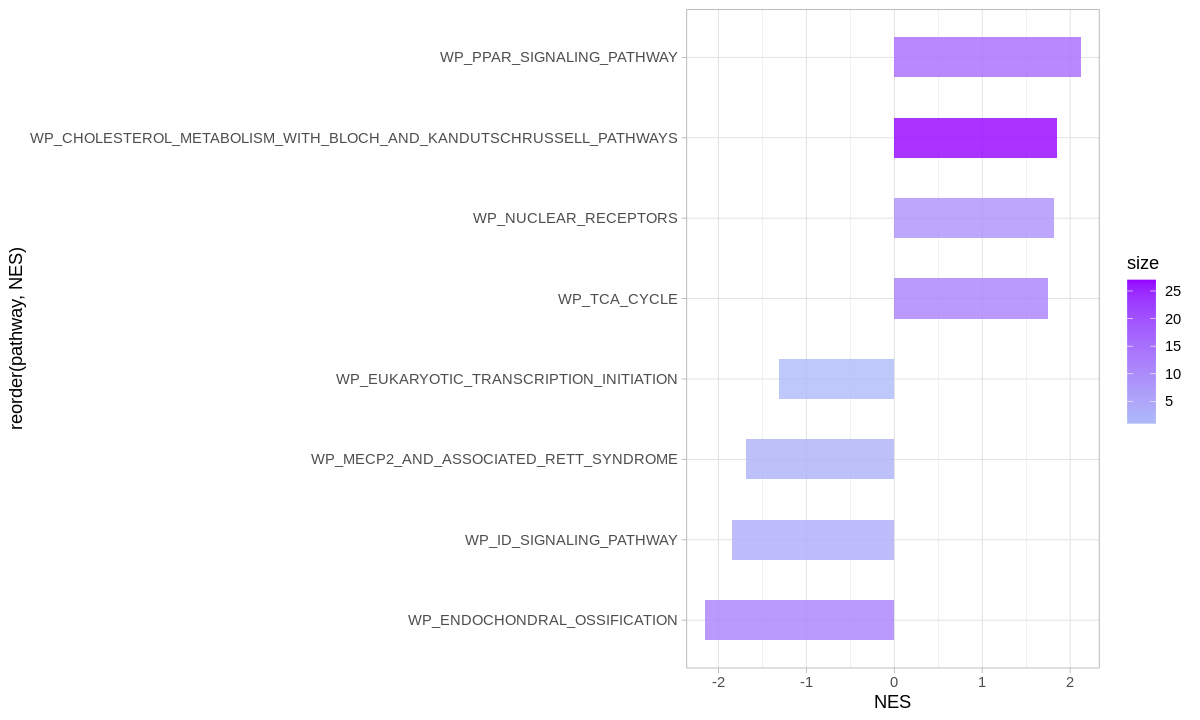

In [20]:
options(repr.plot.width = 10, repr.plot.height = 6, repr.point.size = 16)
ggplot((fgsea_r1_unique %>% filter(padj < 0.35) %>% arrange(desc(size))), 
    aes(x = reorder(pathway, NES), y = NES, fill = size)) +
    geom_bar(stat ="identity", width = 0.5, alpha = 0.8) +
    coord_flip() +
 #   labs(x="Pathways", y="Number of genes", fill="Adjusted P-value (log10)", title = paste0("Pathway enrichment using ", database)) +
    theme(axis.text=element_text(size=20)) + 
    theme(legend.position="none") +
    theme(axis.text.x = element_text(color="black", 
                            size=20),
            axis.text.y = element_text(color="black", 
                            size=20)) +
    theme_light() + scale_fill_gradient(
    low = "#AEBAF8", 
    high = "#9600FF"
    )

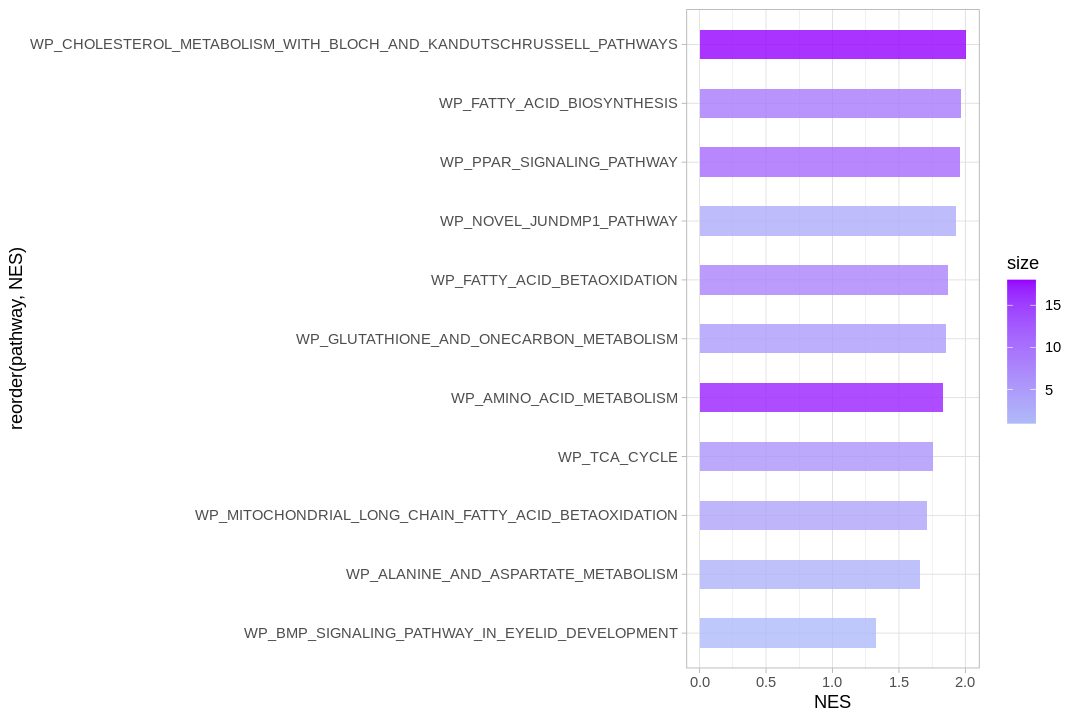

In [18]:
options(repr.plot.width = 9, repr.plot.height = 6, repr.point.size = 16)
ggplot((fgsea_r2_unique %>% filter(padj < 0.25) %>% arrange(desc(size))), 
    aes(x = reorder(pathway, NES), y = NES, fill = size)) +
    geom_bar(stat ="identity", width = 0.5, alpha = 0.8) +
    coord_flip() +
 #   labs(x="Pathways", y="Number of genes", fill="Adjusted P-value (log10)", title = paste0("Pathway enrichment using ", database)) +
    theme(axis.text=element_text(size=20)) + 
    theme(legend.position="none") +
    theme(axis.text.x = element_text(color="black", 
                            size=20),
            axis.text.y = element_text(color="black", 
                            size=20)) +
    theme_light() + scale_fill_gradient(
    low = "#AEBAF8", 
    high = "#9600FF"
    )

## TF 1st neighbors

In [25]:
tf_enrichr <- read.delim("01_raw_data/gsea/MSigDB_Hallmark_2020_tf.txt", sep = "\t")

In [27]:
tf_enrichr <- tf_enrichr %>% filter(Adjusted.P.value < 0.05)


In [35]:
tf_enrichr <- tf_enrichr %>% arrange(desc(Combined.Score))

In [39]:
tf_enrichr$Term <- factor(tf_enrichr$Term, levels = tf_enrichr$Term) %>% fct_rev()

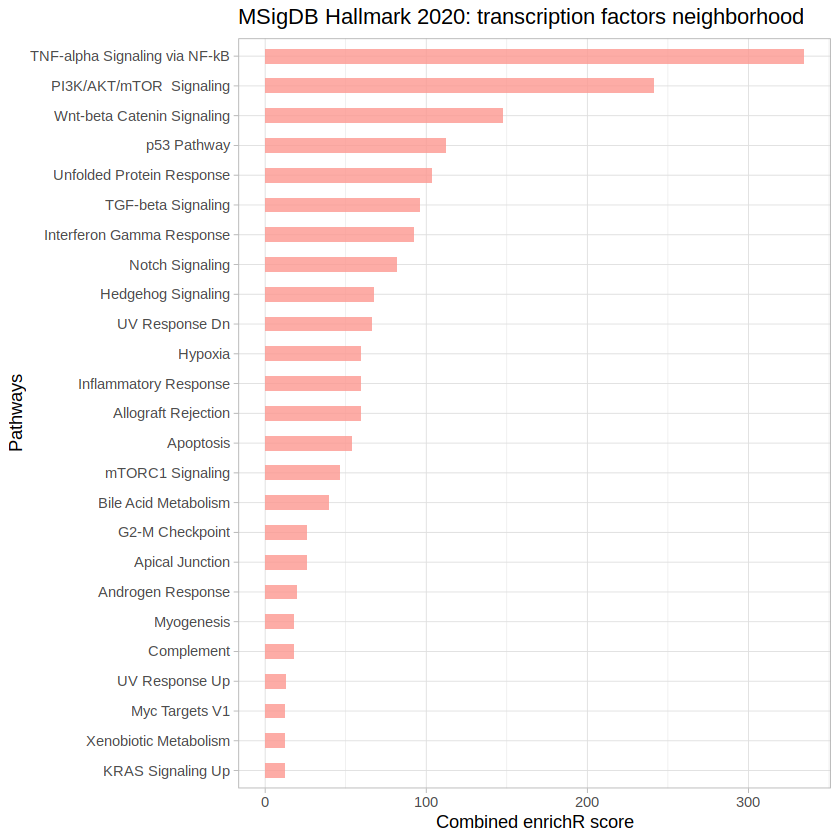

In [43]:
tf_p <- ggplot(tf_enrichr, aes(x= Term, y=Combined.Score)) +
  geom_bar(stat ="identity", fill="#fc9790", width = 0.5, alpha = 0.8) +
  coord_flip() +
  labs(x="Pathways", y="Combined enrichR score", fill="", title = "MSigDB Hallmark 2020: transcription factors neighborhood") +
  theme(axis.text=element_text(size=10)) + 
  theme(legend.position="none") +
 theme(axis.text.x = element_text(color="black", 
                           size=14),
          axis.text.y = element_text(color="black", 
                           size=14)) +
    theme_light() 
tf_p 

## Outputs

In [88]:
ggsave("03_outputs/10/enrichr_kc_cd63.png", p_1, device = "png") 
ggsave("03_outputs/10/enrichr_kc_marco.png", p_2, device = "png") 

Saving 6.67 x 6.67 in image
Saving 6.67 x 6.67 in image


In [205]:
ggsave("03_outputs/10/reactome_ccl4_cir_up.png", p_ccl4_up, device = "png") 
ggsave("03_outputs/10/reactome_ccl4_cir_down.png", p_ccl4_down, device = "png") 
ggsave("03_outputs/10/reactome_taa_cir_up.png", p_taa_up, device = "png") 
ggsave("03_outputs/10/reactome_taa_cir_down.png", p_taa_down, device = "png") 

Saving 6.67 x 6.67 in image
Saving 6.67 x 6.67 in image
Saving 6.67 x 6.67 in image
Saving 6.67 x 6.67 in image


In [203]:
ggsave("03_outputs/10/reactome_intersect_cir_up.png", p_cir_up_intersect, device = "png", width = 8) 
ggsave("03_outputs/10/reactome_intersect_cir_down.png", p_cir_down_intersect, device = "png", width = 8)

Saving 8 x 6.67 in image
Saving 8 x 6.67 in image


In [284]:
ggsave("03_outputs/10/msigdb_pro_rec_up.png", p_pro_rec_up, device = "png", width = 8) 
ggsave("03_outputs/10/msigdb_pro_rec_down.png", p_pro_rec_down, device = "png", width = 8) 
ggsave("03_outputs/10/msigdb_anti_up.png", p_anti_rec_up, device = "png", width = 8) 
ggsave("03_outputs/10/msigdb_anti_down.png", p_anti_rec_down, device = "png", width = 8) 

Saving 8 x 6.67 in image
Saving 8 x 6.67 in image
Saving 8 x 6.67 in image
Saving 8 x 6.67 in image


In [504]:
ggsave("03_outputs/10/hallmark_wgcna_pp.png", p_pp, device = "png", width = 8) 
ggsave("03_outputs/10/hallmark_wgcna_reg.png", p_reg, device = "png", width = 8) 
ggsave("03_outputs/10/hallmark_wgcna_cpa.png", p_cpa, device = "png", width = 8) 
ggsave("03_outputs/10/hallmark_wgcna_cir.png", p_cirrhosis, device = "png", width = 8) 
ggsave("03_outputs/10/hallmark_wgcna_alt.png", p_alt, device = "png", width = 8) 
ggsave("03_outputs/10/hallmark_wgcna_ast.png", p_ast, device = "png", width = 8) 

Saving 8 x 6.67 in image
Saving 8 x 6.67 in image
Saving 8 x 6.67 in image
Saving 8 x 6.67 in image
Saving 8 x 6.67 in image
Saving 8 x 6.67 in image


In [513]:
write.csv(pp_gsea, "03_outputs/10/hallmark_wgcna_pp_markers.csv")
write.csv(reg_gsea , "03_outputs/10/hallmark_wgcna_reg_markers.csv")
write.csv(cpa_gsea, "03_outputs/10/hallmark_wgcna_cpa_markers.csv")
write.csv(cir_gsea, "03_outputs/10/hallmark_wgcna_cirrhosis_markers.csv")
write.csv(alt_gsea, "03_outputs/10/hallmark_wgcna_alt_markers.csv")
write.csv(ast_gsea, "03_outputs/10/hallmark_wgcna_ast_markers.csv")


In [96]:
ggsave("03_outputs/10/ccl4_up_reg.png", p_ccl4_up_reg, device = "png") 
ggsave("03_outputs/10/ccl4_down_reg.png", p_ccl4_down_reg, device = "png") 
ggsave("03_outputs/10/taa_up_reg.png", p_taa_up_reg, device = "png") 
ggsave("03_outputs/10/taa_down_reg.png", p_taa_down_reg, device = "png") 
ggsave("03_outputs/10/intersect_reg_up.png", p_cir_up_intersect_reg, device = "png") 
ggsave("03_outputs/10/intersect_reg_down.png", p_cir_down_intersect_reg, device = "png") 

Saving 6.67 x 6.67 in image
Saving 6.67 x 6.67 in image
Saving 6.67 x 6.67 in image
Saving 6.67 x 6.67 in image
Saving 6.67 x 6.67 in image
Saving 6.67 x 6.67 in image
